In [1]:
# # How to get the data
# !wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
# !gunzip imagenet-sample-train.tar.gz
# !tar xvf imagenet-sample-train.tar

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import foolbox
import tqdm
import imageio
from torchvision import transforms
from torch.autograd import Variable
from pathlib import Path
from PIL import Image

In [37]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, numpy_array):
        tensor = torch.from_numpy(numpy_array)
        return super().__call__(tensor.clone())

In [3]:
with open("./ilsvrc_synsets.txt") as file:
    data = file.read().strip()

index_names = []
index_name_to_string_name = dict()
string_name_to_index_name = dict()
for line in data.split("\n"):
    names, *full_name = line.split(",")
    parts = names.split(" ")
    index_name = parts[0]
    string_name = " ".join(parts[1:])
    index_names.append(index_name)
    index_name_to_string_name[index_name] = string_name
    string_name_to_index_name[string_name] = index_name

In [14]:
# load dataset
# mean = np.array([0.485, 0.456, 0.406])#.reshape((3, 1, 1))
# std = np.array([0.229, 0.224, 0.225])#.reshape((3, 1, 1))

# imagenet_data = torchvision.datasets.ImageFolder(
#     '/data/imagenet_sample_train/', 
#     transform=transform, )

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     normalize,
# ])

# load model
model = torchvision.models.resnet50(pretrained=True, )
model.eval()

# prep Foolbox model
fmodel = foolbox.models.PyTorchModel(
    model, 
    bounds=(-3,3), 
    num_classes=1000,)

# define attack model
attack = foolbox.attacks.FGSM(fmodel)

In [15]:
# net_input = transform(Image.open(images[0]))
# net_input = net_input.unsqueeze(0)
# net_input = net_input.to('cuda')

# output = model(net_input)
# output = output.cpu().detach().numpy()
# output = np.argmax(output)

# output

# fresult = fmodel.forward(net_input.cpu().numpy())
# fresult = np.argmax(fresult)

# fresult

# images[0].parent.stem

# images[0].parent.stem == index_names[982]

# index_names.index('n10148035')

# net_input.min()

# net_input.max()

In [74]:
images[0].stem

'n10148035_9681'

In [101]:
foo = Image.open(image)

In [102]:
foo.getbands()

('L',)

In [103]:
# counters and auxiliary
i = 0
correct = 0
classifier_failed = 0
adversary_succeeded = 0
adversary_failed = 0
adv_examples = []
epsilon = 0.5

# images
images = list(Path('/data/imagenet_sample_train/').glob("./*/*.JPEG"))

# transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

untransform = transforms.Compose([
    NormalizeInverse(mean=mean, std=std),
    transforms.ToPILImage()
])

# attack variables
attack_name = "fgsm"
attack = foolbox.attacks.FGSM(fmodel)
attack_image_folder = "./imagenet/" + attack_name + "/"
!mkdir -p $attack_image_folder

# for image in images
for image in images:
    # load it, transform it
    net_input_PIL = Image.open(image)

    # check for B&W
    if net_input_PIL.getbands() == ('L',):
        i += 1
        print("B&W image")
        continue

    net_input = transform(Image.open(image))
    net_input = net_input.unsqueeze(0)
    
    # get its label
    image_input, label = net_input, index_names.index(image.parent.stem)

    # Forward pass the data through the model, classify it
    output = fmodel.forward(image_input.numpy())
    init_pred = np.argmax(output) # get the index of the max log-probability

    if init_pred != label:
        i += 1
        print((i, init_pred, "!=", label))
        classifier_failed += 1
        continue
        
    # perturb it
    adversarial = attack(image_input.squeeze().numpy(), label)
    if adversarial is None:
        i += 1
        adversary_failed += 1
        continue
    
    # Re-classify the perturbed image, classify it again
    adv_output = fmodel.forward(np.expand_dims(adversarial, 0))
    perturbed_pred = np.argmax(adv_output)

    adversary_succeeded += 1
    unnormalized = adversarial.copy()
    unnormalized[0,:,:] = adversarial[0,:,:] * std[0] + mean[0]
    unnormalized[1,:,:] = adversarial[1,:,:] * std[1] + mean[1]
    unnormalized[2,:,:] = adversarial[2,:,:] * std[2] + mean[2]
    unnormalized = unnormalized * 256
    unnormalized = unnormalized.astype(np.uint8)
    unnormalized = np.rollaxis(unnormalized, 0, 3)
    unnormalized_PIL = Image.fromarray(unnormalized)
    adversarial_image_filename = attack_image_folder + attack_name + "_" + image.stem + "_" + str(label) + "_" + str(perturbed_pred)+ ".png"
    unnormalized_PIL.save(adversarial_image_filename)
    i += 1
    
    # Check for success, save if successful
#     adversary_succeeded += 1
#     adversarial = np.rollaxis(adversarial, 0, 3)
#     adversarial = adversarial * 255
#     adversarial = adversarial.astype(np.uint8)
#     imageio.imsave(attack_image_folder + attack_name + "_" + str(i) + "_" + str(label) + "_" + str(perturbed_pred)+ ".png", adversarial)
#     del adversarial
#     with open(attack_image_folder + attack_name + "_" + str(i) + ".txt", "w") as file:
#         file.write(str(perturbed_pred))

# Calculate final accuracy for this epsilon
print("Classifier fail {} / Adversarial fail {} / Adversarial success {}".format(classifier_failed, adversary_failed, adversary_succeeded))

(13, 834, '!=', 982)
(18, 905, '!=', 982)
(19, 529, '!=', 982)
(33, 215, '!=', 218)
(36, 217, '!=', 218)
(41, 496, '!=', 218)
(44, 156, '!=', 218)
(53, 639, '!=', 638)
(54, 416, '!=', 638)
(57, 639, '!=', 638)
(58, 639, '!=', 638)
(59, 639, '!=', 638)
(60, 552, '!=', 638)
(63, 112, '!=', 638)
(64, 639, '!=', 638)
(65, 639, '!=', 638)
(66, 639, '!=', 638)
(67, 817, '!=', 638)
(68, 610, '!=', 638)
(70, 639, '!=', 638)
(71, 639, '!=', 638)
(72, 445, '!=', 638)
(74, 639, '!=', 638)
(75, 433, '!=', 638)
(76, 639, '!=', 638)
(77, 445, '!=', 638)
(78, 639, '!=', 638)
(82, 637, '!=', 448)
B&W image
(96, 437, '!=', 448)
(129, 865, '!=', 886)
(133, 32, '!=', 31)
(141, 32, '!=', 31)
(160, 695, '!=', 975)
(161, 979, '!=', 975)
(163, 460, '!=', 975)
(164, 978, '!=', 975)
(168, 460, '!=', 975)
(175, 449, '!=', 975)
(177, 449, '!=', 975)
(179, 979, '!=', 975)
(180, 976, '!=', 975)
(182, 978, '!=', 975)
B&W image
(184, 449, '!=', 975)
(185, 814, '!=', 975)
B&W image
(206, 400, '!=', 630)
(207, 834, '!

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [65]:
print(adversarial.shape)

print(unnormalized.shape)
unnormalized = adversarial.copy()
unnormalized[0,:,:] = adversarial[0,:,:] * std[0] + mean[0]
unnormalized[1,:,:] = adversarial[1,:,:] * std[1] + mean[1]
unnormalized[2,:,:] = adversarial[2,:,:] * std[2] + mean[2]
unnormalized = unnormalized * 256
unnormalized = unnormalized.astype(np.uint8)
unnormalized = np.rollaxis(unnormalized, 0, 3)
print(unnormalized.shape)

(3, 224, 224)
(3, 224, 224)
(224, 224, 3)


In [68]:
unnormalized_PIL = Image.fromarray(unnormalized)

In [70]:
final_test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

normalized_unnormalized = final_test_transform(unnormalized_PIL)
normalized_unnormalized = normalized_unnormalized.unsqueeze(0)

foo_output = fmodel.forward(normalized_unnormalized.numpy())
foo_pred = np.argmax(foo_output)
print(foo_pred)

793


In [72]:
unnormalized_PIL.save("test_PIL_save.png")

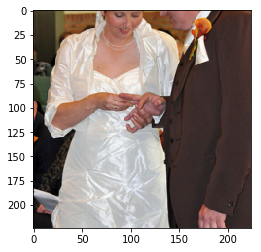

In [66]:
plt.imshow(unnormalized)

In [80]:
foo_pred

793

In [18]:
image_input.squeeze(0).numpy().shape

(3, 224, 224)

In [10]:
# # ./data/imagenet_data/n01440764/

# images = list(Path('/data/imagenet_sample_train/').glob("./*/*.JPEG"))

# # def load_image(image_path):
# #     pass

# def get_imagenet_label(image_path):
#     pass

# # image, label = imagenet_data[0]

# # image

# # label

In [9]:
# # Accuracy counter
# correct = 0
# classifier_failed = 0
# adversary_succeeded = 0
# adversary_failed = 0
# adv_examples = []
# epsilon = 0.5

# attack = foolbox.attacks.FGSM(fmodel)
# attack_name = "fgsm"
# attack_image_folder = "./imagenet/" + attack_name + "/"
# !mkdir -p $attack_image_folder

# # with open("./checkpoint.txt") as file:
# #     last_checked = int(file.read())

# # Loop over all examples in test set
# for i in tqdm.tqdm_notebook(range(len(imagenet_data))):

# #     with open("./checkpoint.txt","w") as file:
# #         file.write(str(i))
    
#     # Send the data and label to the device
#     image, target = imagenet_data[i]
    
#     # Forward pass the data through the model
#     output = fmodel.forward(np.expand_dims(image, 0, ))
#     init_pred = np.argmax(output) # get the index of the max log-probability

#     # If the initial prediction is wrong, dont bother attacking, just move on
#     if init_pred != target:
#         classifier_failed += 1
#         continue

#     # Call FGSM Attack
#     adversarial = attack(image.numpy(), target)
#     del image
#     if adversarial is None:
#         adversary_failed += 1
#         del adversarial
#         continue
    
#     # Re-classify the perturbed image
#     adv_output = fmodel.forward(np.expand_dims(adversarial, 0))
#     perturbed_pred = np.argmax(adv_output)

#     # Check for success
#     adversary_succeeded += 1
#     adversarial = np.rollaxis(adversarial, 0, 3)
#     adversarial = adversarial * 255
#     adversarial = adversarial.astype(np.uint8)
#     imageio.imsave(attack_image_folder + attack_name + "_" + str(i) + "_" + str(target) + "_" + str(perturbed_pred)+ ".png", adversarial)
#     del adversarial
#     with open(attack_image_folder + attack_name + "_" + str(i) + ".txt", "w") as file:
#         file.write(str(perturbed_pred))
    
            
# # Calculate final accuracy for this epsilon
# final_acc = correct/float(len(imagenet_data))
# print("Classifier fail {} / Adversarial fail {} / Adversarial success {}".format(classifier_failed, adversary_failed, adversary_succeeded))

In [12]:
final_acc = correct/float(len(imagenet_data))
print("Classifier fail {} / Adversarial fail {} / Adversarial success {}".format(classifier_failed, adversary_failed, adversary_succeeded))

Classifier fail 19372 / Adversarial fail 0 / Adversarial success 67


In [ ]:
len(list(Path('./imagenet/fgsm/').glob("*.png")))

(3, 224, 263)
(224, 263, 3)


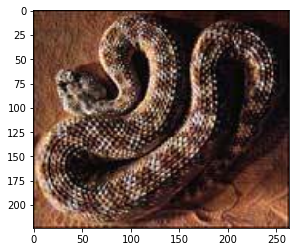

In [42]:
test, label = imagenet_data[1000]
test = np.array(test)
test_2 = np.moveaxis(test, 0, 2)
print(test.shape)
print(test_2.shape)
plt.imshow(test_2)

In [44]:
output = fmodel.forward(np.expand_dims(test, 0, ))
init_pred = np.argmax(output) # get the index of the max log-probability

In [45]:
label

39

In [46]:
init_pred

68

In [50]:
test.shape

(3, 224, 263)

In [49]:
test_2.shape

(224, 263, 3)

In [58]:
import torchvision.models as models
cnn = models.resnet50(pretrained=True)
test_image = np.expand_dims(test, 0, )
print(test_image.shape)
test = torch.from_numpy(test_image).float()


(1, 3, 224, 263)


In [59]:
out = cnn(test)

In [60]:
print(out.shape)

torch.Size([1, 1000])


In [64]:
value,index = out.max(0)

In [67]:
import torch.nn as nn
softmax_test = nn.functional.softmax(out,dim =1).data

In [68]:
values, index = torch.topk(softmax_test,1)

In [69]:
print(index)

tensor([[463]])
